In [112]:
import classification_utils
import unet_utils
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import segmentation_models as sm
from tensorflow import keras
import os
from sklearn.model_selection import cross_val_score
from joblib import dump, load
from dtreeviz.trees import dtreeviz
from sklearn import tree
path = '/hpf/largeprojects/tabori/users/yuan/lmp1210/data/classification/'
WRITE=False

In [2]:
#load UNet model
sm.set_framework('tf.keras')
sm.framework()
#define model
BACKBONE = 'vgg19'
CLASSES = ['NCI', 'GCI','_background_']
preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, encoder_weights=None,classes=3, activation='softmax',input_shape=(None, None, 3),encoder_freeze=True)
model.load_weights('tuning_model_000_newbase.h5')

2022-04-09 13:23:16.896553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpf/largeprojects/tabori/users/yuan/software/anaconda/tf/lib/python3.10/site-packages/cv2/../../lib64:/hpf/tools/centos7/tcltk/8.6.11/lib:/hpf/tools/centos6/gdal/2.4.0/lib/:/hpf/tools/centos6/netcdf/4.3.2/lib/:/hpf/tools/centos6/libtiff/4.0.9/lib/:/hpf/tools/centos7/sqlite/3.35.3/lib:/hpf/tools/centos7/proj/7.2.0/lib:/hpf/tools/centos6/geos/3.4.2/lib:/hpf/tools/centos6/libpng/1.2.59/lib/:/hpf/tools/centos7/udunits2/2.2.28/lib:/hpf/tools/centos7/hdf5/1.10.5/lib:/hpf/tools/centos7/R/4.0.4_pbalin/lib64:/hpf/tools/centos7/pcre/8.44.utf8/lib:/hpf/tools/centos7/libxml2/2.9.1/lib64:/hpf/tools/centos7/curl/7.74.0/lib:/hpf/tools/centos7/readline/8.1/lib:/hpf/tools/centos6/gcc/7.2.0/lib64/:/hpf/tools/centos6/gcc/7.2.0/lib/:/hpf/tools/centos7/python/3.9.2_pbalin

In [3]:
def predictFig(path):
    imgs = classification_utils.crop_image(path)
    imgs = preprocess_input(imgs)
    pr_all = model.predict_on_batch(imgs)
    pr_all_raw = pr_all
    pr_all = unet_utils.threshold(pr_all,0.99,0.99)
    return pr_all, pr_all_raw

In [4]:
if WRITE==True:
    #model predicts all data
    # predictions = pd.DataFrame(columns=['sample_name','NCI_pixels','GCI_pixels','total_pixels'])
    sample_name=[]
    NCI_pixels=[]
    GCI_pixels=[]
    NCI_prob_sum=[]
    GCI_prob_sum=[]
    total_pixels=[]
    tags = ['LBD_SN','LBD_CWM','MSA_SN','MSA_CWM']
    for j in tags:
        #we have #11-#70 as training data
        for i in range(11,71):
            pr_all,pr_all_raw = predictFig(os.path.join(path,'train',j,f'{j}_{i}.tif'))
            NCI_pixels.append(np.count_nonzero(pr_all[...,0] == 1))
            GCI_pixels.append(np.count_nonzero(pr_all[...,1] == 1))
            NCI_prob_sum.append(np.sum(pr_all_raw[...,0]))
            GCI_prob_sum.append(np.sum(pr_all_raw[...,1]))
            total_pixels.append(pr_all.size)
            sample_name.append(f'{j}_{i}')
            print(f'finish for {j}_{i}')
    predictions = pd.DataFrame({'sample_name':sample_name,
                                'NCI_pixels':NCI_pixels,
                                'GCI_pixels':GCI_pixels,
                                'NCI_prob_sum':NCI_prob_sum,
                                'GCI_prob_sum':GCI_prob_sum,
                                'total_pixels':total_pixels})
    predictions.to_csv('classification_predictions.csv')

In [5]:
predictions = pd.read_csv('classification_predictions.csv')
predictions

,Unnamed: 0,sample_name,NCI_pixels,GCI_pixels,NCI_prob_sum,GCI_prob_sum,total_pixels
0,0,LBD_SN_11,26367,3594,66586.7600,23310.045,6291456
1,1,LBD_SN_12,41685,1916,94784.3500,14340.057,6291456
2,2,LBD_SN_13,46117,13512,112872.9500,47227.890,6291456
3,3,LBD_SN_14,28472,9200,103196.3600,42533.420,6291456
4,4,LBD_SN_15,14638,5116,44814.3830,24552.635,6291456
...,...,...,...,...,...,...,...
235,235,MSA_CWM_66,0,20584,2986.6067,32150.380,1572864
236,236,MSA_CWM_67,3,22236,3637.2798,35835.953,1572864
237,237,MSA_CWM_68,0,14163,3079.8070,24122.580,1572864
238,238,MSA_CWM_69,8,16127,2845.4424,24735.832,1572864


In [130]:
features = pd.DataFrame({
    'sample_name':predictions.sample_name,
    'NCI_norm':predictions.NCI_pixels/predictions.total_pixels,
    'GCI_norm':predictions.GCI_pixels/predictions.total_pixels,
    'NCI_GCI_ratio':predictions.NCI_pixels/predictions.GCI_pixels,
    'NCI_prob_norm':predictions.NCI_prob_sum/predictions.total_pixels,
    'GCI_prob_norm':predictions.GCI_prob_sum/predictions.total_pixels,
    'NCI_GCI_prob_ratio':predictions.NCI_prob_sum/predictions.GCI_prob_sum,
                        }).fillna(0)
features.replace([np.inf, -np.inf], 99, inplace=True)

In [131]:
#match each SN to all CWM to simulate more data point
#eg. LBD_SN_11 would match LBD_CWM_11 to LBD_CWM_70
#So 1 pair becomes 60 pairs which gives us more datapoints and reduce individual differences

for i in range(0,60):
    for j in range(60,120):
        if (i==0 and j==60):

            feature_LBD=np.expand_dims(np.append(features.iloc[i,1:],features.iloc[j,1:]),axis=0)
        else:
            feature_LBD=np.concatenate(
                (np.expand_dims(np.append(features.iloc[i,1:],features.iloc[j,1:]),axis=0),
                 feature_LBD)
            )            

for i in range(120,180):
    for j in range(180,240):
        if i==120 and j==180:
            feature_MSA=np.expand_dims(np.append(features.iloc[i,1:],features.iloc[j,1:]),axis=0)
        else:
            feature_MSA=np.concatenate(
                (np.expand_dims(np.append(features.iloc[i,1:],features.iloc[j,1:]),axis=0),
                 feature_MSA)
            )

features_cross_matched = np.concatenate((feature_LBD,feature_MSA))
np.shape(features_cross_matched)

(7200, 12)

In [132]:
# #match each SN to all CWM to simulate more data point
# #eg. LBD_SN_11 would match LBD_CWM_11 to LBD_CWM_70
# #So 1 pair becomes 60 pairs which gives us more datapoints and reduce individual differences

# for i,j in zip(range(0,60),range(60,120)):
#         if (i==0 and j==60):

#             feature_LBD=np.expand_dims(np.append(features.iloc[i,1:],features.iloc[j,1:]),axis=0)
#         else:
#             feature_LBD=np.concatenate(
#                 (np.expand_dims(np.append(features.iloc[i,1:],features.iloc[j,1:]),axis=0),
#                  feature_LBD)
#             )            

# for i,j in zip(range(120,180),range(180,240)):
#         if i==120 and j==180:
#             feature_MSA=np.expand_dims(np.append(features.iloc[i,1:],features.iloc[j,1:]),axis=0)
#         else:
#             feature_MSA=np.concatenate(
#                 (np.expand_dims(np.append(features.iloc[i,1:],features.iloc[j,1:]),axis=0),
#                  feature_MSA)
                
#             )

# features_cross_matched = np.concatenate((feature_LBD,feature_MSA))
# np.shape(features_cross_matched)

In [133]:
X_train = pd.DataFrame(
    {
        'NCI_norm_SN':features_cross_matched[:,0],
        'GCI_norm_SN':features_cross_matched[:,1],
        'NCI_GCI_ratio_SN':features_cross_matched[:,2],
#         'NCI_prob_norm_SN':features_cross_matched[:,3],
#         'GCI_prob_norm_SN':features_cross_matched[:,4],
#         'NCI_GCI_prob_ratio_SN':features_cross_matched[:,5],
        'NCI_norm_CWM':features_cross_matched[:,6],
        'GCI_norm_CWM':features_cross_matched[:,7],
        'NCI_GCI_ratio_CWM':features_cross_matched[:,8],
#         'NCI_prob_norm_CWM':features_cross_matched[:,9],
#         'GCI_prob_norm_CWM':features_cross_matched[:,10],
#         'NCI_GCI_prob_ratio_CWM':features_cross_matched[:,11]
    }
)
#LBD=0, MSA=1
y_train = ([0]*3600+[1]*3600)

#normalize
# X_train = (X_train-X_train.mean())/X_train.std()
X_train = (X_train-X_train.min())/(X_train.max()-X_train.min())
X_train

,NCI_norm_SN,GCI_norm_SN,NCI_GCI_ratio_SN,NCI_norm_CWM,GCI_norm_CWM,NCI_GCI_ratio_CWM
0,0.469402,0.211271,0.119433,0.0,0.000056,0.0
1,0.469402,0.211271,0.119433,0.003284,0.0,1.0
2,0.469402,0.211271,0.119433,0.0,0.0,0.0
3,0.469402,0.211271,0.119433,0.0,0.0,0.0
4,0.469402,0.211271,0.119433,0.0,0.0,0.0
...,...,...,...,...,...,...
7195,0.003786,0.012965,0.006216,0.0,0.044747,0.0
7196,0.003786,0.012965,0.006216,0.0,0.0322,0.0
7197,0.003786,0.012965,0.006216,0.0,0.064625,0.0
7198,0.003786,0.012965,0.006216,0.0,0.040655,0.0


In [134]:
clf = DecisionTreeClassifier(random_state=42,max_depth=4,splitter='random')
dt = clf.fit(X_train, y_train)
print(cross_val_score(clf, X_train, y_train, cv=10))
dump(dt, 'decision_tree.joblib') 

[1.     1.     1.     1.     0.975  1.     1.     1.     1.     0.9875]


['decision_tree.joblib']

In [135]:
clf2=LogisticRegression(random_state=42)
lgr = clf2.fit(X_train, y_train)
print(cross_val_score(clf2, X_train, y_train, cv=10))
dump(lgr, 'logistic_regression.joblib') 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


['logistic_regression.joblib']

/hpf/largeprojects/tabori/users/yuan/software/anaconda/tf/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


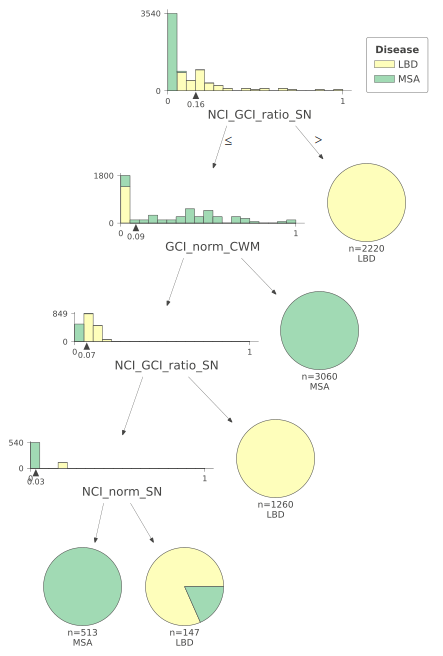

In [136]:

viz = dtreeviz(dt, 
               np.array(X_train), 
               np.array(y_train),
               target_name='Disease',
               feature_names=], 
               class_names=['LBD','MSA']
              )  
              
viz

In [110]:
print(dt.score(X_train,y_train))
print(lgr.score(X_train,y_train))

0.99625
1.0
